# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

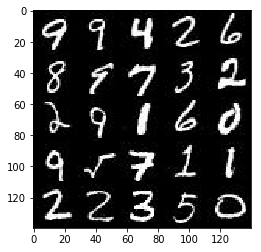

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

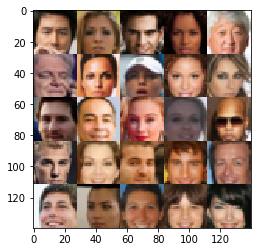

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/goncalossilva/.conda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, name="lr")

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
from math import ceil

def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):        
        # Input is 28x28xC. 
        
        l = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        l = tf.nn.leaky_relu(l, alpha=alpha)
        
        # Now 14x14x64.
        
        l = tf.layers.conv2d(l, 128, 5, strides=2, padding='same')
        l = tf.layers.batch_normalization(l, training=True)
        l = tf.nn.leaky_relu(l, alpha=alpha)
        
        # Now 7x7x128.
        
        l = tf.layers.conv2d(l, 256, 5, strides=2, padding='same')
        l = tf.layers.batch_normalization(l, training=True)
        l = tf.nn.leaky_relu(l, alpha=alpha)
        
        # Now 4x4x256.
        
        l = tf.layers.conv2d(l, 512, 5, strides=2, padding='same')
        l = tf.layers.batch_normalization(l, training=True)
        l = tf.nn.leaky_relu(l, alpha=alpha)
        
        # Now 2x2x512.
        
        l = tf.reshape(l, (-1, 2 * 2 * 512))
        logits = tf.layers.dense(l, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=(not is_train)):
        # Fully connected layer.
        l = tf.layers.dense(z, 4 * 4 * 512)
        
        # Convolutional layer.
        l = tf.reshape(l, (-1, 4, 4, 512))
        l = tf.layers.batch_normalization(l, training=is_train)
        l = tf.nn.relu(l)
        
        # Now 2x2x512.
        
        l = tf.layers.conv2d_transpose(l, 256, 4, strides=1, padding='valid')
        l = tf.layers.batch_normalization(l, training=is_train)
        l = tf.nn.relu(l)
        
        # Now 7x7x256.
        
        l = tf.layers.conv2d_transpose(l, 128, 5, strides=2, padding='same')
        l = tf.layers.batch_normalization(l, training=is_train)
        l = tf.nn.relu(l)
        
        # Now 14x14x128.
        
        logits = tf.layers.conv2d_transpose(l, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        # Now 28x28xout_channel_dim.
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_output = generator(input_z, out_channel_dim)
    d_output_real, d_logits_real = discriminator(input_real)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_output_fake)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_output_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_output_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every_steps=10, show_every_steps=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    # Create input placeholders.
    _, w, h, c = data_shape
    input_real, input_z, lr = model_inputs(w, h, c, z_dim)

    # Create losses and optimizers.
    d_loss, g_loss = model_loss(input_real, input_z, c)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    # Setup training.
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Scale images from [-0.5,0.5] range to [-1,1].
                batch_images = batch_images*2
                
                # Sample random noise for the generator.
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers.
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                # Print progress.
                step += 1
                if step % print_every_steps == 0:
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))
                
                # Show progress.
                if (step % show_every_steps == 0):
                    show_generator_output(sess, 25, input_z, c, data_image_mode)
                    
        # Show progress at the very end.
        show_generator_output(sess, 25, input_z, c, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.7660... Generator Loss: 0.0988
Epoch 1/2... Discriminator Loss: 0.1240... Generator Loss: 10.7713
Epoch 1/2... Discriminator Loss: 0.4377... Generator Loss: 15.7570
Epoch 1/2... Discriminator Loss: 0.0116... Generator Loss: 9.5396
Epoch 1/2... Discriminator Loss: 0.5300... Generator Loss: 1.0143
Epoch 1/2... Discriminator Loss: 0.0441... Generator Loss: 6.4011
Epoch 1/2... Discriminator Loss: 0.0783... Generator Loss: 8.9246
Epoch 1/2... Discriminator Loss: 5.0735... Generator Loss: 15.5864
Epoch 1/2... Discriminator Loss: 0.0698... Generator Loss: 5.1175
Epoch 1/2... Discriminator Loss: 0.0536... Generator Loss: 5.5202


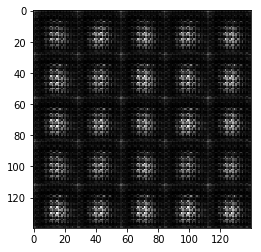

Epoch 1/2... Discriminator Loss: 0.0386... Generator Loss: 3.4467
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 11.5086
Epoch 1/2... Discriminator Loss: 0.3266... Generator Loss: 9.5090
Epoch 1/2... Discriminator Loss: 0.0517... Generator Loss: 5.9292
Epoch 1/2... Discriminator Loss: 0.0854... Generator Loss: 9.6542
Epoch 1/2... Discriminator Loss: 0.0216... Generator Loss: 8.1276
Epoch 1/2... Discriminator Loss: 0.0030... Generator Loss: 16.8876
Epoch 1/2... Discriminator Loss: 0.0412... Generator Loss: 10.6703
Epoch 1/2... Discriminator Loss: 0.0274... Generator Loss: 11.5661
Epoch 1/2... Discriminator Loss: 0.0709... Generator Loss: 3.2397


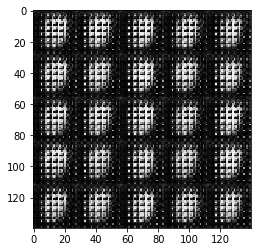

Epoch 1/2... Discriminator Loss: 0.1158... Generator Loss: 9.6892
Epoch 1/2... Discriminator Loss: 0.2339... Generator Loss: 1.6879
Epoch 1/2... Discriminator Loss: 1.4491... Generator Loss: 0.4917
Epoch 1/2... Discriminator Loss: 0.3003... Generator Loss: 2.2102
Epoch 1/2... Discriminator Loss: 0.8706... Generator Loss: 1.3466
Epoch 1/2... Discriminator Loss: 0.5337... Generator Loss: 5.0257
Epoch 1/2... Discriminator Loss: 0.5411... Generator Loss: 1.6932
Epoch 1/2... Discriminator Loss: 0.3884... Generator Loss: 2.3867
Epoch 1/2... Discriminator Loss: 0.2255... Generator Loss: 2.3385
Epoch 1/2... Discriminator Loss: 0.3325... Generator Loss: 1.9501


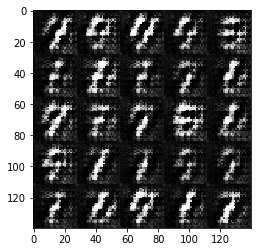

Epoch 1/2... Discriminator Loss: 0.2009... Generator Loss: 2.4574
Epoch 1/2... Discriminator Loss: 0.3563... Generator Loss: 1.5705
Epoch 1/2... Discriminator Loss: 0.4575... Generator Loss: 11.4598
Epoch 1/2... Discriminator Loss: 0.4353... Generator Loss: 1.5575
Epoch 1/2... Discriminator Loss: 0.2004... Generator Loss: 2.5286
Epoch 1/2... Discriminator Loss: 0.2995... Generator Loss: 3.0407
Epoch 1/2... Discriminator Loss: 0.5576... Generator Loss: 1.2207
Epoch 1/2... Discriminator Loss: 0.6148... Generator Loss: 2.2800
Epoch 1/2... Discriminator Loss: 1.6412... Generator Loss: 0.3554
Epoch 1/2... Discriminator Loss: 0.7155... Generator Loss: 1.0311


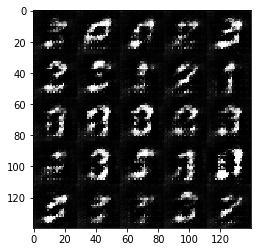

Epoch 1/2... Discriminator Loss: 0.4257... Generator Loss: 1.7725
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 1.3361
Epoch 1/2... Discriminator Loss: 0.5732... Generator Loss: 1.8219
Epoch 1/2... Discriminator Loss: 1.1472... Generator Loss: 0.5544
Epoch 1/2... Discriminator Loss: 0.5478... Generator Loss: 1.3113
Epoch 1/2... Discriminator Loss: 0.7813... Generator Loss: 1.0404
Epoch 1/2... Discriminator Loss: 0.4321... Generator Loss: 3.5219
Epoch 1/2... Discriminator Loss: 0.7201... Generator Loss: 4.3810
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 3.0479
Epoch 1/2... Discriminator Loss: 0.6159... Generator Loss: 1.4401


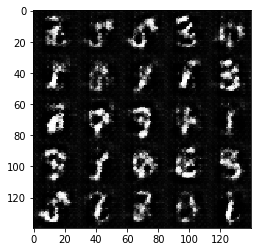

Epoch 1/2... Discriminator Loss: 1.0598... Generator Loss: 0.7008
Epoch 1/2... Discriminator Loss: 0.6774... Generator Loss: 1.1917
Epoch 1/2... Discriminator Loss: 0.7700... Generator Loss: 3.3290
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 0.6872
Epoch 1/2... Discriminator Loss: 0.7094... Generator Loss: 4.0117
Epoch 1/2... Discriminator Loss: 0.8693... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 0.7172... Generator Loss: 1.1885
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 0.5676
Epoch 1/2... Discriminator Loss: 0.5901... Generator Loss: 1.8435
Epoch 1/2... Discriminator Loss: 0.8823... Generator Loss: 1.1840


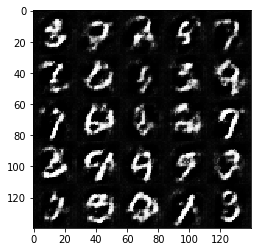

Epoch 1/2... Discriminator Loss: 0.9319... Generator Loss: 1.5743
Epoch 1/2... Discriminator Loss: 1.6849... Generator Loss: 0.2869
Epoch 1/2... Discriminator Loss: 0.9045... Generator Loss: 0.7489
Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 0.4838
Epoch 1/2... Discriminator Loss: 0.8106... Generator Loss: 1.2194
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 0.8393
Epoch 1/2... Discriminator Loss: 0.7041... Generator Loss: 0.9817
Epoch 1/2... Discriminator Loss: 0.7713... Generator Loss: 1.3281
Epoch 1/2... Discriminator Loss: 0.9019... Generator Loss: 0.7409
Epoch 1/2... Discriminator Loss: 0.9625... Generator Loss: 0.7349


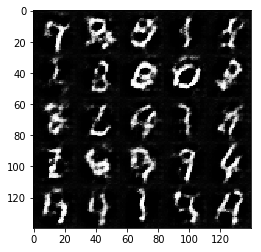

Epoch 1/2... Discriminator Loss: 0.6788... Generator Loss: 1.2050
Epoch 1/2... Discriminator Loss: 0.7970... Generator Loss: 1.3114
Epoch 1/2... Discriminator Loss: 0.6598... Generator Loss: 1.7778
Epoch 1/2... Discriminator Loss: 1.0411... Generator Loss: 2.0603
Epoch 1/2... Discriminator Loss: 0.7693... Generator Loss: 1.0415
Epoch 2/2... Discriminator Loss: 0.7447... Generator Loss: 1.2280
Epoch 2/2... Discriminator Loss: 1.6184... Generator Loss: 3.6199
Epoch 2/2... Discriminator Loss: 0.7036... Generator Loss: 1.6527
Epoch 2/2... Discriminator Loss: 0.7786... Generator Loss: 1.0746
Epoch 2/2... Discriminator Loss: 0.9841... Generator Loss: 0.7062


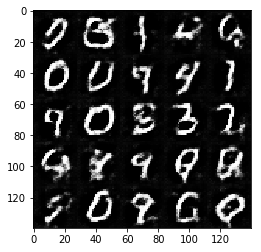

Epoch 2/2... Discriminator Loss: 1.6145... Generator Loss: 0.2981
Epoch 2/2... Discriminator Loss: 0.7632... Generator Loss: 1.4677
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 0.7025
Epoch 2/2... Discriminator Loss: 0.9200... Generator Loss: 0.7832
Epoch 2/2... Discriminator Loss: 0.6908... Generator Loss: 1.2743
Epoch 2/2... Discriminator Loss: 0.6730... Generator Loss: 1.3093
Epoch 2/2... Discriminator Loss: 0.8207... Generator Loss: 0.9838
Epoch 2/2... Discriminator Loss: 0.5991... Generator Loss: 1.7110
Epoch 2/2... Discriminator Loss: 0.7336... Generator Loss: 1.0111
Epoch 2/2... Discriminator Loss: 0.6888... Generator Loss: 1.8419


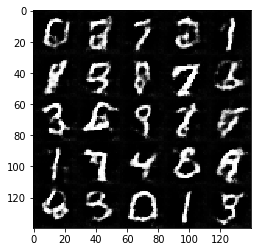

Epoch 2/2... Discriminator Loss: 0.5430... Generator Loss: 1.2963
Epoch 2/2... Discriminator Loss: 0.6662... Generator Loss: 1.7613
Epoch 2/2... Discriminator Loss: 0.8165... Generator Loss: 1.0818
Epoch 2/2... Discriminator Loss: 0.7220... Generator Loss: 1.1571
Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 1.5107
Epoch 2/2... Discriminator Loss: 0.6944... Generator Loss: 1.0287
Epoch 2/2... Discriminator Loss: 0.6633... Generator Loss: 1.4560
Epoch 2/2... Discriminator Loss: 0.5177... Generator Loss: 1.6039
Epoch 2/2... Discriminator Loss: 0.6962... Generator Loss: 2.3684
Epoch 2/2... Discriminator Loss: 0.7614... Generator Loss: 1.2666


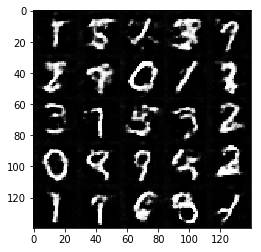

Epoch 2/2... Discriminator Loss: 0.8799... Generator Loss: 0.8636
Epoch 2/2... Discriminator Loss: 0.6823... Generator Loss: 1.2058
Epoch 2/2... Discriminator Loss: 0.8603... Generator Loss: 1.0051
Epoch 2/2... Discriminator Loss: 0.6653... Generator Loss: 1.7062
Epoch 2/2... Discriminator Loss: 0.5727... Generator Loss: 1.2696
Epoch 2/2... Discriminator Loss: 0.6524... Generator Loss: 1.0935
Epoch 2/2... Discriminator Loss: 1.5165... Generator Loss: 0.3344
Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 0.7562
Epoch 2/2... Discriminator Loss: 0.8711... Generator Loss: 2.3040
Epoch 2/2... Discriminator Loss: 0.6380... Generator Loss: 1.4898


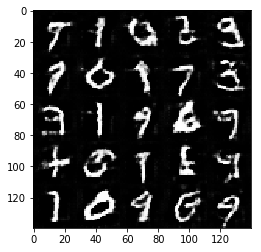

Epoch 2/2... Discriminator Loss: 0.7054... Generator Loss: 1.0376
Epoch 2/2... Discriminator Loss: 1.2032... Generator Loss: 0.4560
Epoch 2/2... Discriminator Loss: 0.8373... Generator Loss: 0.7917
Epoch 2/2... Discriminator Loss: 0.7684... Generator Loss: 0.9573
Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 0.5743
Epoch 2/2... Discriminator Loss: 0.4894... Generator Loss: 1.7594
Epoch 2/2... Discriminator Loss: 1.5822... Generator Loss: 0.3104
Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 0.8021
Epoch 2/2... Discriminator Loss: 0.9173... Generator Loss: 0.6867
Epoch 2/2... Discriminator Loss: 0.8278... Generator Loss: 0.8226


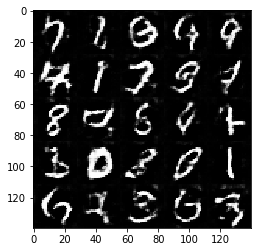

Epoch 2/2... Discriminator Loss: 0.9113... Generator Loss: 0.7398
Epoch 2/2... Discriminator Loss: 0.7691... Generator Loss: 1.0634
Epoch 2/2... Discriminator Loss: 0.6355... Generator Loss: 1.0584
Epoch 2/2... Discriminator Loss: 0.6228... Generator Loss: 1.1487
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 0.7892
Epoch 2/2... Discriminator Loss: 2.3018... Generator Loss: 0.1846
Epoch 2/2... Discriminator Loss: 0.7040... Generator Loss: 1.0606
Epoch 2/2... Discriminator Loss: 0.8252... Generator Loss: 1.0220
Epoch 2/2... Discriminator Loss: 0.5072... Generator Loss: 1.3150
Epoch 2/2... Discriminator Loss: 0.9507... Generator Loss: 0.6841


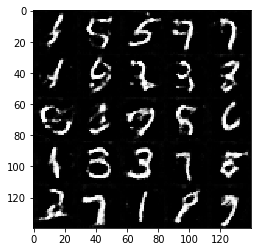

Epoch 2/2... Discriminator Loss: 0.5950... Generator Loss: 1.5517
Epoch 2/2... Discriminator Loss: 1.0364... Generator Loss: 0.5651
Epoch 2/2... Discriminator Loss: 0.6304... Generator Loss: 1.3951
Epoch 2/2... Discriminator Loss: 1.4193... Generator Loss: 2.8791
Epoch 2/2... Discriminator Loss: 0.8449... Generator Loss: 0.8212
Epoch 2/2... Discriminator Loss: 0.6499... Generator Loss: 1.3421
Epoch 2/2... Discriminator Loss: 0.8061... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 1.0544... Generator Loss: 0.6079
Epoch 2/2... Discriminator Loss: 1.9789... Generator Loss: 0.2706
Epoch 2/2... Discriminator Loss: 1.1246... Generator Loss: 0.6457


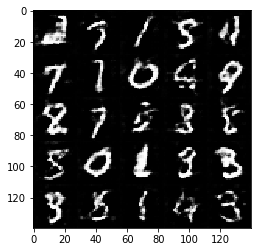

Epoch 2/2... Discriminator Loss: 0.8857... Generator Loss: 0.7468
Epoch 2/2... Discriminator Loss: 0.7447... Generator Loss: 0.9335
Epoch 2/2... Discriminator Loss: 0.7995... Generator Loss: 0.8712
Epoch 2/2... Discriminator Loss: 0.8350... Generator Loss: 0.8343
Epoch 2/2... Discriminator Loss: 1.2111... Generator Loss: 0.4842
Epoch 2/2... Discriminator Loss: 0.6852... Generator Loss: 0.9786
Epoch 2/2... Discriminator Loss: 0.9710... Generator Loss: 0.6254
Epoch 2/2... Discriminator Loss: 1.8207... Generator Loss: 0.2492
Epoch 2/2... Discriminator Loss: 0.9907... Generator Loss: 0.6615
Epoch 2/2... Discriminator Loss: 0.5602... Generator Loss: 1.3694


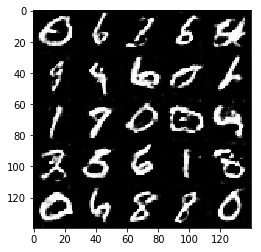

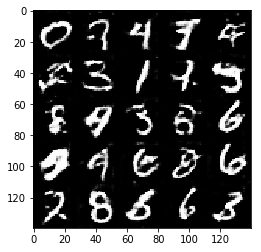

In [12]:
batch_size = 80
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 14.7228
Epoch 1/1... Discriminator Loss: 0.0385... Generator Loss: 16.2317
Epoch 1/1... Discriminator Loss: 2.0280... Generator Loss: 0.1641
Epoch 1/1... Discriminator Loss: 5.9219... Generator Loss: 0.0030
Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 7.8130
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 7.4704
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.3730
Epoch 1/1... Discriminator Loss: 0.1261... Generator Loss: 3.3459
Epoch 1/1... Discriminator Loss: 0.2563... Generator Loss: 1.6923
Epoch 1/1... Discriminator Loss: 0.2196... Generator Loss: 4.3744


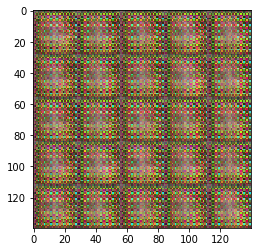

Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 2.9678
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 2.0188
Epoch 1/1... Discriminator Loss: 0.3281... Generator Loss: 3.0882
Epoch 1/1... Discriminator Loss: 0.2859... Generator Loss: 2.8235
Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 5.5724
Epoch 1/1... Discriminator Loss: 0.3317... Generator Loss: 2.1682
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 2.1610


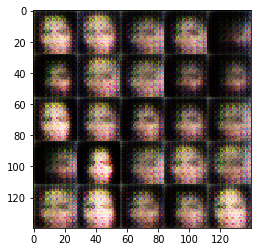

Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 1.3939
Epoch 1/1... Discriminator Loss: 0.6687... Generator Loss: 4.2738
Epoch 1/1... Discriminator Loss: 1.8071... Generator Loss: 0.2661
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 2.9248


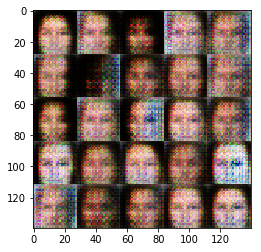

Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 2.2541
Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 2.9340
Epoch 1/1... Discriminator Loss: 0.3749... Generator Loss: 2.8204
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 0.7717... Generator Loss: 1.6035
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 3.0920
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 1.3144
Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 2.6784
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 2.1082


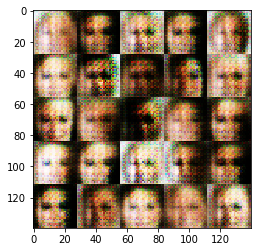

Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.4055
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 0.7895... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 2.8927
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 1.4900
Epoch 1/1... Discriminator Loss: 0.3725... Generator Loss: 2.2211
Epoch 1/1... Discriminator Loss: 0.4297... Generator Loss: 1.8012


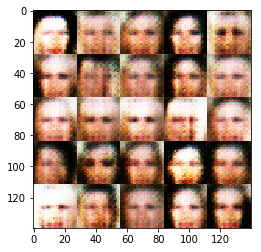

Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 2.1556
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 1.8364
Epoch 1/1... Discriminator Loss: 1.8490... Generator Loss: 3.7455
Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.4139
Epoch 1/1... Discriminator Loss: 0.6008... Generator Loss: 1.7334
Epoch 1/1... Discriminator Loss: 0.5524... Generator Loss: 2.1966
Epoch 1/1... Discriminator Loss: 0.3438... Generator Loss: 2.9051
Epoch 1/1... Discriminator Loss: 0.5413... Generator Loss: 1.4325


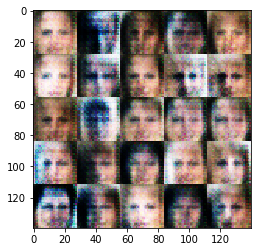

Epoch 1/1... Discriminator Loss: 0.5784... Generator Loss: 1.8572
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.5997
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.4374
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.4468
Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.9459
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 1.2599
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.6007


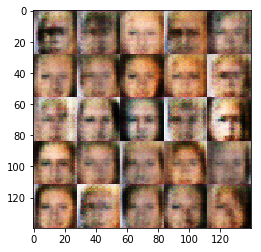

Epoch 1/1... Discriminator Loss: 0.7076... Generator Loss: 1.4625
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 1.5189
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 3.0849
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.2671
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 2.2345
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.6396


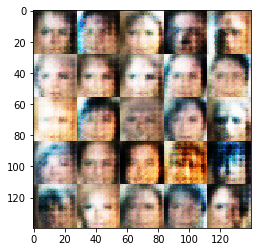

Epoch 1/1... Discriminator Loss: 0.5831... Generator Loss: 1.2735
Epoch 1/1... Discriminator Loss: 2.2193... Generator Loss: 5.2487
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 1.1261
Epoch 1/1... Discriminator Loss: 0.7376... Generator Loss: 1.1215
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 1.6941
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 1.0583
Epoch 1/1... Discriminator Loss: 0.6159... Generator Loss: 2.3038
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 1.3087


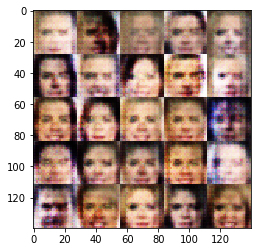

Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.1850
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 2.6334
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 1.3028
Epoch 1/1... Discriminator Loss: 0.8134... Generator Loss: 1.8697
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.6143
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 3.0775
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.1936


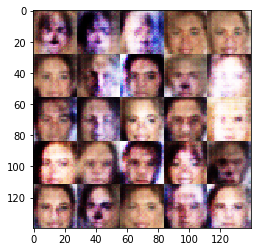

Epoch 1/1... Discriminator Loss: 0.6330... Generator Loss: 2.0172
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 3.3305
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 1.3290
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 2.5615
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 2.5127
Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.2576
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 1.3735
Epoch 1/1... Discriminator Loss: 1.7587... Generator Loss: 5.5594
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 0.8503


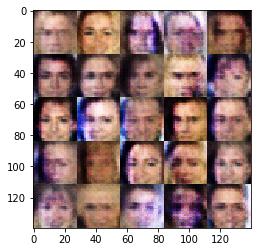

Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 1.8817
Epoch 1/1... Discriminator Loss: 0.5852... Generator Loss: 1.3157
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 1.3932
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 2.1028
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 1.0532
Epoch 1/1... Discriminator Loss: 0.6454... Generator Loss: 1.8704
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.0168


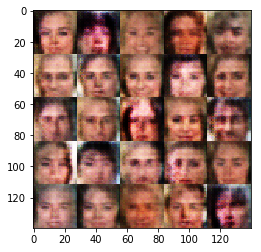

Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 1.1575
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 1.6180
Epoch 1/1... Discriminator Loss: 0.7260... Generator Loss: 1.1591
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 0.6172... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 1.9464
Epoch 1/1... Discriminator Loss: 0.6231... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 1.1916


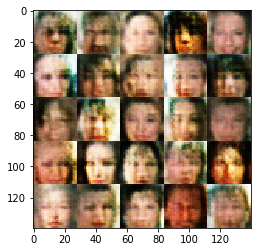

Epoch 1/1... Discriminator Loss: 0.7664... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 3.1583
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 1.7527
Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 1.5657
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 0.4406... Generator Loss: 1.7631
Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 1.7185
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 3.6021
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.3508


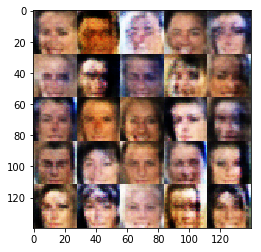

Epoch 1/1... Discriminator Loss: 0.7129... Generator Loss: 1.8231
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 1.6366
Epoch 1/1... Discriminator Loss: 2.4425... Generator Loss: 4.9162
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 0.8740... Generator Loss: 1.2224
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.7191


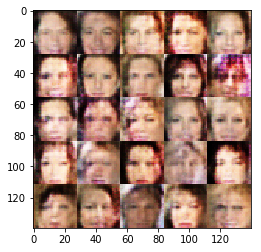

Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 0.5775... Generator Loss: 1.4915
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 1.4784
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 2.1990
Epoch 1/1... Discriminator Loss: 0.6136... Generator Loss: 1.2292
Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 2.5159
Epoch 1/1... Discriminator Loss: 0.5432... Generator Loss: 1.1931
Epoch 1/1... Discriminator Loss: 3.6133... Generator Loss: 5.9973


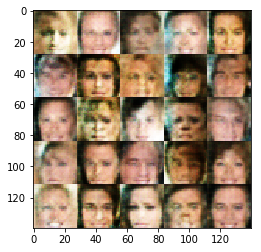

Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 1.1769
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.8958
Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 1.2887
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 1.1225
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 1.4640


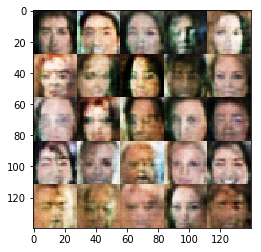

Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 1.5133
Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 1.5579
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 1.6193
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.4493
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 1.3545
Epoch 1/1... Discriminator Loss: 0.6738... Generator Loss: 1.5517


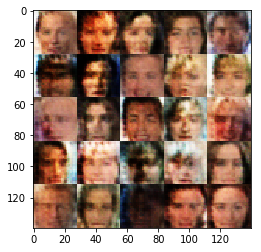

Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 1.6972
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 0.5741... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 2.1625
Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 1.4417
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.8650
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 0.6691


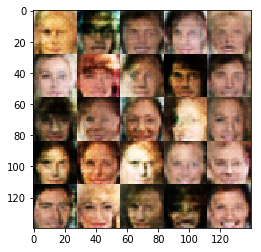

Epoch 1/1... Discriminator Loss: 0.5827... Generator Loss: 1.4458
Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 1.4085
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 2.1157
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 2.7591
Epoch 1/1... Discriminator Loss: 0.6294... Generator Loss: 1.4006
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.3440
Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 1.3133
Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 1.3392
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.3400


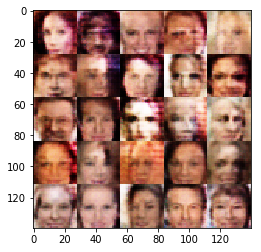

Epoch 1/1... Discriminator Loss: 0.7213... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.7070
Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 1.1047
Epoch 1/1... Discriminator Loss: 1.7991... Generator Loss: 0.2824
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.4519
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 1.2331
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 1.6643


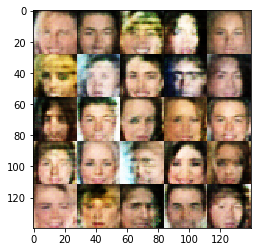

Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 3.2638
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 1.4637
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 2.6268
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.3277
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 0.6853... Generator Loss: 1.0856


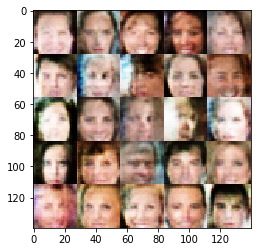

Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 1.2637
Epoch 1/1... Discriminator Loss: 0.2812... Generator Loss: 2.0711
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 2.0032
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 1.6926
Epoch 1/1... Discriminator Loss: 0.7331... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.2950


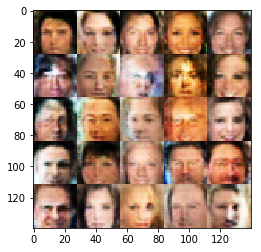

Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 2.4748
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 1.1561
Epoch 1/1... Discriminator Loss: 0.4603... Generator Loss: 1.4622
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 0.7639... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 0.4517... Generator Loss: 1.4727
Epoch 1/1... Discriminator Loss: 0.6835... Generator Loss: 1.6902


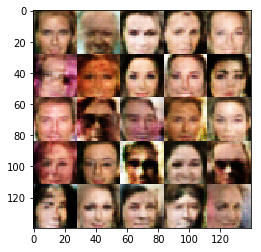

Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.3797
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 2.7792
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 0.5712... Generator Loss: 1.7340


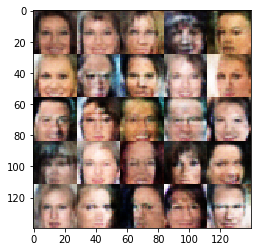

Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 1.1819
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 2.1212
Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 1.5449


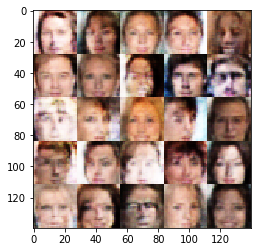

In [13]:
batch_size = 80
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

## Development notes

This network started as a mirror of the network proposed in the DCGAN paper. However, results weren't great, particularly when working with the MNIST dataset. Some of the generated digits were easily recognizable, but most were not. After some experimentation, the limited number of epochs seems to be the main culprit, as temporarily adding more yields better results.

In the end, the best architecture for the imposed constraints was a slightly simplified version of the DCGAN network, with 2 less layers on the generator and 1 less layer on the discriminator, half of the filters at each layer, and a smaller batch size. Considering the project's constraints, it was the one that displayed the best results and the one that's implemented above.

More and/or deeper layers led to better overall results, but only when the network was allowed to train for more epochs. Less and/or shallower layers led to worse overall results, as the network seemed to fail to fit the data. The default batch size (128) was also beneficial when training for a little longer, but reducing it provided better results within the allowed epochs. My intuition is that the network doesn't have to generalize as much this way, which is not great when training for longer, but better for this specific project. Finally, tweaking other hyper parameters such as the learning rate or the decay didn't show improvements over DCGAN's proposed values.

The advantages of doubling epochs and using the proposed batch size on both problems, even on the simplified network, are shown below.

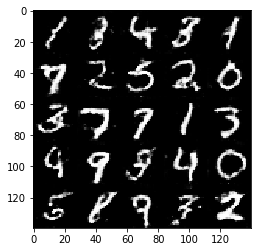

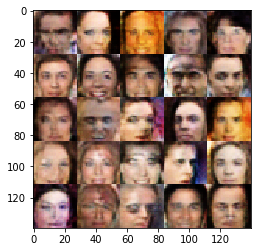

In [14]:
import sys

batch_size = 128

# MNIST.
epochs = 4
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, sys.maxsize, sys.maxsize)
    
# CelebA.
epochs = 2
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, sys.maxsize, sys.maxsize)